In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")
import plotly.graph_objects as go
import plotly.express as px
from sklearn.datasets import make_swiss_roll
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data,z=make_swiss_roll(n_samples=5000,noise=0.05)
#data[:,1] *=2
swissrolldata=pd.DataFrame(data,columns=['x1','x2','x3'])

In [3]:
ward=AgglomerativeClustering(n_clusters=6,linkage='ward').fit(swissrolldata)
labels=ward.labels_
swissrolldata['labels']=labels

In [4]:
swissrolldata.head()

x1         x2        x3  labels
0  4.428709  11.848811  5.586237       2
1 -9.382074  19.407466  0.151960       0
2  3.011977  12.602455 -4.317454       3
3 -9.429583   1.564528 -1.808117       0
4  4.417986   5.235437 -3.506306       3

In [5]:
swissrolldata.corr()

x1        x2        x3    labels
x1      1.000000 -0.018355  0.102721  0.760920
x2     -0.018355  1.000000 -0.018392 -0.241236
x3      0.102721 -0.018392  1.000000  0.133332
labels  0.760920 -0.241236  0.133332  1.000000

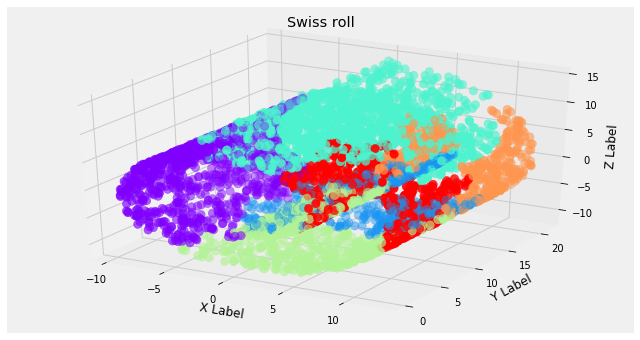

In [6]:
#%matplotlib qt
%matplotlib inline
xdim=swissrolldata['x1']
ydim=swissrolldata['x2']
zdim=swissrolldata['x3']
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111,projection='3d')
ax.scatter(xdim,ydim,zdim,c=swissrolldata['labels'],cmap="rainbow",s=70)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title("Swiss roll")
plt.show()

In [7]:
fig=px.scatter_3d(swissrolldata,x='x1',y='x2',z='x3',color='labels')
fig.update_traces(marker=dict(size=5,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

# Locally linear Embedding

In [8]:
from sklearn.manifold import LocallyLinearEmbedding

In [9]:
lle=LocallyLinearEmbedding(n_components=2,n_neighbors=10)
data=swissrolldata.drop('labels',axis=1)
newdata=lle.fit_transform(data)
newdata=pd.DataFrame(newdata,columns=['z1','z2'])
newdata['labels']=labels

In [10]:
newdata.head()

z1        z2  labels
0  0.012326 -0.003284       2
1  0.002145 -0.011074       0
2  0.018500 -0.012013       3
3  0.000969  0.013900       0
4  0.017965  0.020697       3

In [11]:
fig=px.scatter(newdata,x='z1',y='z2',color='labels')
fig.update_traces(marker=dict(size=5,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

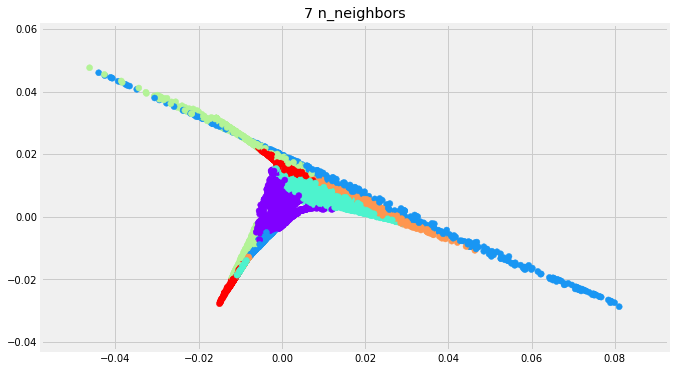

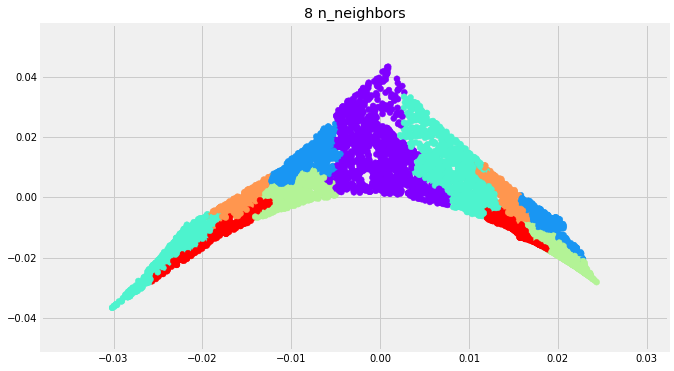

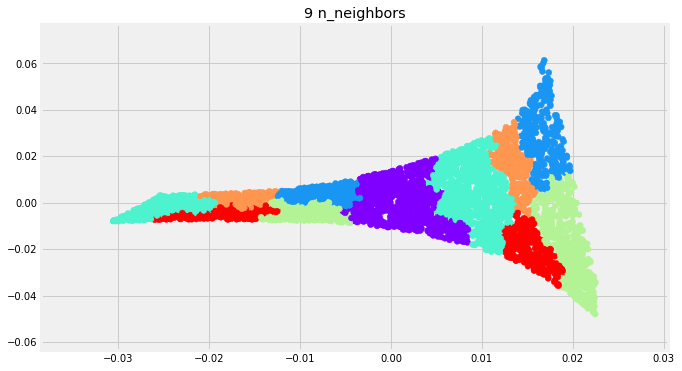

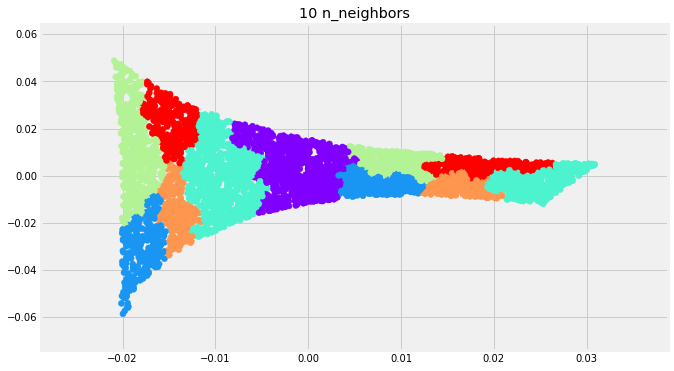

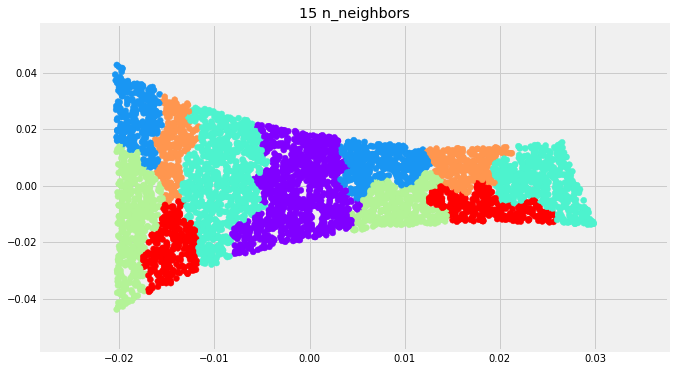

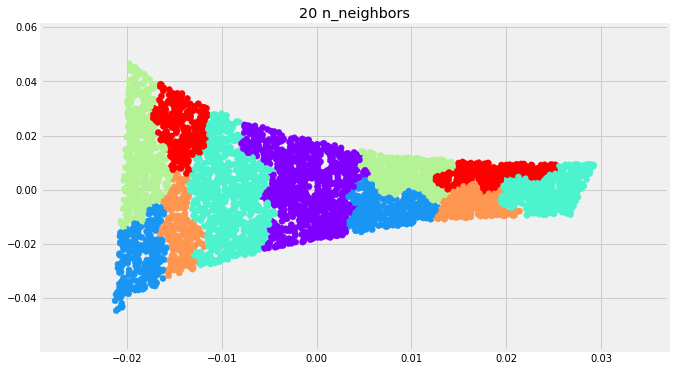

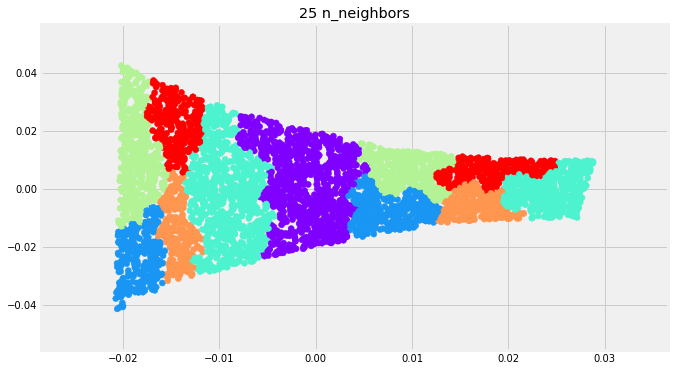

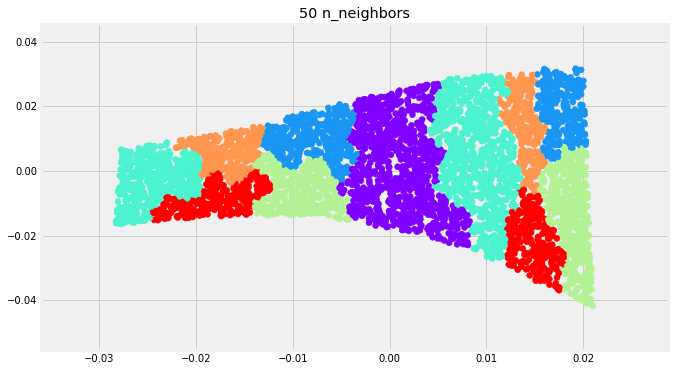

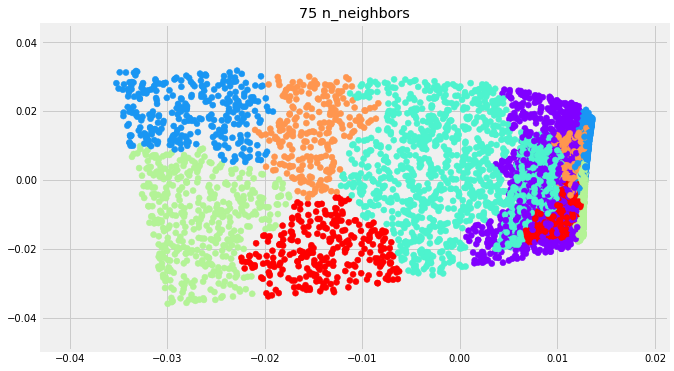

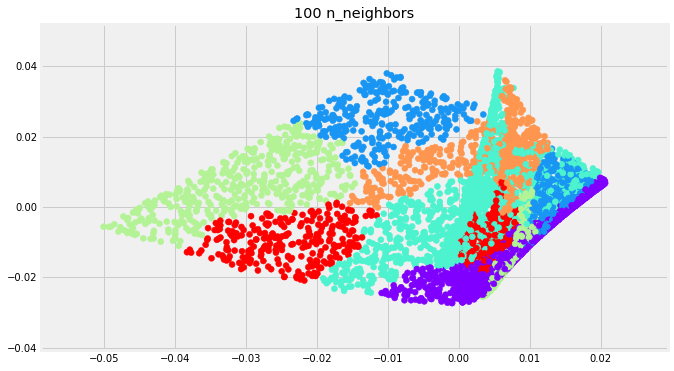

In [12]:
for i in [7,8,9,10,15,20,25,50,75,100]:
    lle=LocallyLinearEmbedding(n_components=2,n_neighbors=i)
    data=swissrolldata.drop('labels',axis=1)
    newdata=lle.fit_transform(data)
    newdata=pd.DataFrame(newdata,columns=['z1','z2'])
    newdata['labels']=labels
    plt.figure(figsize=(10,6))
    plt.scatter(newdata['z1'],newdata['z2'],c=newdata['labels'],cmap='rainbow')
    plt.title(f"{i} n_neighbors")
    plt.show()

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [14]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=500),
    "adaboost":AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=500,
                           algorithm="SAMME.R",learning_rate=0.5),
    "xgboost":XGBClassifier()}

In [15]:
no=len(dict_classifiers.keys())
def classifiers(data,labels):
    results = pd.DataFrame(data=np.zeros(shape=(no,4)),
                columns =['classifier','train_score','validation score','training_time'])
    count=0  
    for key,classifier in dict_classifiers.items():
        start = time.clock()
        lle=LocallyLinearEmbedding(n_components=2,n_neighbors=10)
        x=lle.fit_transform(data)
        y=labels
        X_train,X_test,Y_train,Y_test=train_test_split(x,y,random_state=32)
        classifier.fit(X_train, Y_train)
        y_pred=classifier.predict(X_test)
        acc=accuracy_score(y_pred,Y_test)
        train_score =classifier.score(X_train, Y_train)
        end = time.clock()
        diff = end-start
        results.loc[count,'classifier']=key
        results.loc[count,'train_score']=train_score
        results.loc[count,'validation score']=acc
        results.loc[count,'training_time']=diff
        count=count+1
    return results

In [16]:
d=swissrolldata.drop('labels',axis=1)
l=swissrolldata['labels']
res=classifiers(d,l)
print(res.sort_values(by='validation score',ascending=False))

                     classifier  train_score  validation score  training_time
5                 Random Forest     1.000000            0.9888       2.608372
1             Nearest Neighbors     0.991733            0.9832       0.731583
7                       xgboost     1.000000            0.9824       1.307456
4                 Decision Tree     1.000000            0.9784       0.529174
3  Gradient Boosting Classifier     0.999467            0.9736       2.688584
2                    Linear SVM     0.919467            0.9304       0.922575
6                      adaboost     0.582133            0.5928       2.517772
0           Logistic Regression     0.268000            0.2544       0.591332


# t-sne

In [17]:
from sklearn.manifold import TSNE

In [18]:
tsne=TSNE(n_components=2)
data=swissrolldata.drop('labels',axis=1)
newdata=tsne.fit_transform(data)
newdata=pd.DataFrame(newdata,columns=['z1','z2'])
newdata['labels']=labels

In [19]:
newdata.head()

z1         z2  labels
0 -21.205212 -38.442184       2
1  14.571681 -71.555397       0
2 -58.798454   5.513733       3
3  67.122078 -32.054218       0
4 -65.138557 -16.890474       3

In [20]:
fig=px.scatter(newdata,x='z1',y='z2',color='labels')
fig.update_traces(marker=dict(size=5,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [21]:
no=len(dict_classifiers.keys())
def classifiers(data,labels):
    results = pd.DataFrame(data=np.zeros(shape=(no,4)),
                columns =['classifier','train_score','validation score','training_time'])
    count=0  
    for key,classifier in dict_classifiers.items():
        start = time.clock()
        tsne=TSNE(n_components=2)
        x=lle.fit_transform(data)
        y=labels
        X_train,X_test,Y_train,Y_test=train_test_split(x,y,random_state=32)
        classifier.fit(X_train, Y_train)
        y_pred=classifier.predict(X_test)
        acc=accuracy_score(y_pred,Y_test)
        train_score =classifier.score(X_train, Y_train)
        end = time.clock()
        diff = end-start
        results.loc[count,'classifier']=key
        results.loc[count,'train_score']=train_score
        results.loc[count,'validation score']=acc
        results.loc[count,'training_time']=diff
        count=count+1
    return results

In [22]:
d=swissrolldata.drop('labels',axis=1)
l=swissrolldata['labels']
res=classifiers(d,l)
print(res.sort_values(by='validation score',ascending=False))

                     classifier  train_score  validation score  training_time
1             Nearest Neighbors     0.866667            0.8016       5.110962
5                 Random Forest     1.000000            0.7808       7.815427
7                       xgboost     0.993067            0.7776       7.345602
3  Gradient Boosting Classifier     0.877867            0.7760       6.847336
4                 Decision Tree     1.000000            0.7672       5.135465
2                    Linear SVM     0.720800            0.7304       6.259154
6                      adaboost     0.333867            0.3560       6.516115
0           Logistic Regression     0.268000            0.2544       4.877392


# Isomap

In [23]:
from sklearn.manifold import Isomap

In [24]:
isomap=Isomap(n_components=2)
data=swissrolldata.drop('labels',axis=1)
newdata=tsne.fit_transform(data)
newdata=pd.DataFrame(newdata,columns=['z1','z2'])
newdata['labels']=labels

In [25]:
newdata.head()

z1         z2  labels
0 -44.059711  14.209806       2
1  -8.157242 -14.166401       0
2 -22.529367  64.807716       3
3 -25.656044 -57.257252       0
4  -2.831083  52.602024       3

In [26]:
fig=px.scatter(newdata,x='z1',y='z2',color='labels')
fig.update_traces(marker=dict(size=5,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [27]:
no=len(dict_classifiers.keys())
def classifiers(data,labels):
    results = pd.DataFrame(data=np.zeros(shape=(no,4)),
                columns =['classifier','train_score','validation score','training_time'])
    count=0  
    for key,classifier in dict_classifiers.items():
        start = time.clock()
        isomap=Isomap(n_components=2)
        x=isomap.fit_transform(data)
        y=labels
        X_train,X_test,Y_train,Y_test=train_test_split(x,y,random_state=32)
        classifier.fit(X_train, Y_train)
        y_pred=classifier.predict(X_test)
        acc=accuracy_score(y_pred,Y_test)
        train_score =classifier.score(X_train, Y_train)
        end = time.clock()
        diff = end-start
        results.loc[count,'classifier']=key
        results.loc[count,'train_score']=train_score
        results.loc[count,'validation score']=acc
        results.loc[count,'training_time']=diff
        count=count+1
    return results

In [28]:
d=swissrolldata.drop('labels',axis=1)
l=swissrolldata['labels']
res=classifiers(d,l)
print(res.sort_values(by='validation score',ascending=False))

                     classifier  train_score  validation score  training_time
7                       xgboost     1.000000            0.9848      10.466054
5                 Random Forest     1.000000            0.9832      12.241361
1             Nearest Neighbors     0.989600            0.9816       9.852352
4                 Decision Tree     1.000000            0.9776      10.251238
3  Gradient Boosting Classifier     0.998400            0.9768      12.742514
2                    Linear SVM     0.924800            0.9368       9.600279
6                      adaboost     0.509067            0.5032      12.147214
0           Logistic Regression     0.350933            0.3720       9.816714
